In [1]:
#############################################################
#
# NBA Individual Player Performance Prediction
#
#############################################################
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())

from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import copy
import pickle

from mrsc.src.model.SVDmodel import SVDmodel
from mrsc.src.model.Target import Target
from mrsc.src.model.Donor import Donor
from mrsc.src.synthcontrol.mRSC import mRSC
from mrsc.src.importData import *
import mrsc.src.utils as utils

from mrsc.src.from_tslib.svdWrapper import SVDWrapper as SVD
from mrsc.src.from_tslib.tsSVDModel import SVDModel
from mrsc.src.from_tslib import tsUtils

from statsmodels.tsa.arima_model import ARMA

plt.rcParams.update({'font.size': 14})

In [2]:
"""
import data
"""
print("*** importing data ***")

annual_pred = pd.read_pickle("annual_pred_2016.pkl")
target_players = list(annual_pred.columns)

data = pd.read_csv("../data/nba-enhanced-stats/2012-18_playerBoxScore.csv")

game_metrics = ['playPTS', 'playAST', 'playTO','playFG%','playFT%','play3PM','playTRB','playSTL', 'playBLK']
year_metrics = ['PTS_G','AST_G','TOV_G','TRB_G','STL_G','BLK_G','3P_G','FG%','FT%']
colname_dict = {'playPTS': 'PTS_G', 'playAST': 'AST_G', 'playTO':'TOV_G',
                'playFG%': 'FG%','playFT%':'FT%','play3PM':'3P_G',
                'playTRB':'TRB_G','playSTL':'STL_G','playBLK':'BLK_G'}

# edit column names to fit with the yearly data
data = data.rename(columns=colname_dict)

date_col = pd.to_datetime(data.gmDate + " " + data.gmTime, format='%Y-%m-%d %H:%M').rename("date")
data = pd.concat([date_col,data], axis=1)

stats_game = data[["date","gmDate","playDispNm"]+year_metrics]
stats_game = stats_game.rename(columns={"playDispNm": "Player"})

*** importing data ***


In [3]:
df = pd.read_pickle("../data/nba-hosoi/nba_scores_2103-2018.pkl")
df = df[["nbaId","path","game_date","home","away","season"]].drop_duplicates().reset_index(drop=True)

a = pd.concat([df,(df["game_date"] + str(" ") + df["home"]).rename("key")], axis=1)
b = pd.concat([df,(df["game_date"] + str(" ") + df["away"]).rename("key")], axis=1)
appended = pd.concat([a,b], axis=0)

In [4]:
new_data = pd.concat([data, (data["gmDate"] + str(" ") + data["teamAbbr"]).rename("key")], axis=1)
data_fin = new_data.merge(appended, how='left', left_on='key', right_on='key')


stats_game = data_fin[["date","gmDate","gmTime","nbaId","playDispNm"]+year_metrics]
stats_game = stats_game.rename(columns={"playDispNm": "Player"})

In [5]:
def mse(actual, pred):
    return ((actual - pred) ** 2).mean()

def rmse(actual, pred):
    return np.sqrt(((actual - pred) ** 2).mean())

def mape(actual, pred):
    actual = pd.DataFrame(actual)
    pred = pd.DataFrame(pred)
    mask = (actual != 0)
    return (np.abs(actual - pred) / actual[mask]).mean()

def window_stack(a, stepsize=1, width=3):
    n = a.shape[0]
    return np.hstack( a[i:1+n+i-width:stepsize] for i in range(0,width) )

In [6]:
# get the EWMA from raw scores
def run_ewma(vals, window):
    # take EWMA in both directions with a smaller span term
    fwd = pd.DataFrame(vals).ewm(span=window).mean().values.flatten() # take EWMA in fwd direction
    bwd = pd.DataFrame(vals[::-1]).ewm(span=window).mean().values.flatten() # take EWMA in bwd direction
    
#     runs_smoothed = np.vstack(( fwd, bwd[::-1] )) # lump fwd and bwd together
#     runs_smoothed = np.mean( runs_smoothed, axis=0 ) # average

    runs_smoothed = 0.7 * fwd + 0.3 * bwd[::-1]
    return runs_smoothed
#     return fwd

def ts_estimate(player_data, player_name, metric, game_date, nbr_innings_to_test, moving_avg_window, nbrSingValuesToKeep):
    
#     player_data # array-like

#     player_stat = stats_game[(stats_game.Player == player_name) & (stats_game.nbaId > 21500000) & (stats_game.nbaId < 21600000)]
#     player_data = player_stat.loc[player_stat.nbaId < game_id, metric].reset_index(drop=True).rename(player_name).to_frame()

    T = player_data.shape[0]
    N = nbr_innings_to_test # nbr of rows
    M = int(T/N) # total nbr of columns
    M1 = M - 1 # nbr of columns for training
    key1 = str(player_name) 

    trainDF = pd.DataFrame(index=range(0, M1*N), data={key1: player_data[0:M1*N]})
    testDF = pd.DataFrame(index=range(0, T - (M1*N)), data={key1: player_data[M1*N: ]})

    mod = SVDModel(key1, nbrSingValuesToKeep, N, M1, probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=[], includePastDataOnly=True)
    mod.fit(trainDF)
    imputedDf = mod.denoisedDF()
    
#     if (player_data.shape[1] != 1):
    player_data = np.reshape(player_data, [1, player_data.shape[0]]).T
    pred_matrix = window_stack(player_data, 1, N-1)
    pred = np.dot(pred_matrix, mod.weights)
    pred = np.concatenate((np.array([np.nan]*(N-1)),pred[:-1]))

#     estimates = np.concatenate((imputedDf[key1].values, forecastArray), axis=0)

#     print("Plotting...")
#     plt.plot(player_data, label="real")
#     plt.plot(player_data_ewma, label="ewma")
#     plt.plot(np.concatenate((imputedDf[key1].values, forecastArray), axis=0), color='blue', label='ts_estimate')
#     plt.axvline(x=len(trainDF), linewidth=1, color='black', label='Training End')
#     legend = plt.legend(loc='upper left', shadow=True)
#     plt.xlabel('Innings Number')
#     plt.ylabel('Runs')
#     plt.title('Player ID = '+player_name)
#     legend = plt.legend(loc='upper left', shadow=False)
#     plt.show()

    return pred, N*M1

def run_analysis(test_period, min_num_game, metric, players_of_interest,start_date,end_date, stats_game, nbr_innings_to_test, moving_avg_window, nbrSingValuesToKeep):
    print("***", metric, "***")
    print("number of players tested: ", len(players_of_interest))
    
    mape_list=[]
    rmse_list_1 = []
    rmse_list_2 = []
    rmse_list_3 = []
    for player_name in players_of_interest:

        player_stat = stats_game[(stats_game.Player == player_name) & (stats_game.date > start_date) & (stats_game.date < end_date)]
        game_date = player_stat.iloc[min_num_game]['date']
    #     print(game_date)

        player_data =  player_stat.loc[player_stat.date < game_date, metric].reset_index(drop=True).rename(player_name).to_frame()
        player_data_ewma = run_ewma(player_data, moving_avg_window)
        player_data_ewma = pd.DataFrame(index=range(0, len(player_data_ewma)), data={player_name: player_data_ewma})

        ts_pred, interv = ts_estimate(player_data_ewma.values.flatten(), player_name, metric, game_date, nbr_innings_to_test, moving_avg_window, nbrSingValuesToKeep)
        ts_pred = pd.DataFrame(index=range(0, len(ts_pred)), data={player_name: ts_pred})
    #     print(ts_pred)

        # recover X(t) - by ewma equation
        alpha = 2/(moving_avg_window+1)
        real_pred = [np.nan]*nbr_innings_to_test
        for loc in range(nbr_innings_to_test,ts_pred.shape[0],1):
            x_t = (ts_pred.iloc[loc] - player_data_ewma.iloc[loc-1] * (1-alpha)).values[0] /alpha
            real_pred.append(x_t)
        real_pred = pd.DataFrame(index=range(0, len(real_pred)), data={player_name: real_pred})
    #     print(real_pred)

        # recover X(t) - by variance estimation
        player_data_var = (player_data - player_data_ewma)
        T = player_data_var.shape[0]
        N = nbr_innings_to_test # nbr of rows
        M = int(T/N) # total nbr of columns
        M1 = M - 1 # nbr of columns for training
        key1 = str(player_name)

        trainDF = player_data_var.iloc[0:M1*N]
        testDF = player_data_var.iloc[M1*N:].reset_index(drop=True)

        mod_var = SVDModel(key1, nbrSingValuesToKeep, N, M1, probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=[], includePastDataOnly=True)
        mod_var.fit(trainDF)

        pred = np.dot(window_stack(np.reshape(player_data_var.values.T,[1,player_data_var.shape[0]]).T, 1, N-1), mod_var.weights)
        pred = np.concatenate((np.array([np.nan]*(N-1)),pred[:-1]))
        var_pred = pd.DataFrame(index=range(0, len(pred)), data={player_name: pred})
        real_pred_2 = ts_pred+var_pred
    #     print(real_pred_2)

        test_mape = mape(player_data_ewma.iloc[interv:interv+test_period],ts_pred.iloc[interv:interv+test_period]).values[0]
        mape_list.append(test_mape)

        # ewma
        test_rmse = rmse(player_data_ewma.iloc[interv:interv+test_period],ts_pred.iloc[interv:interv+test_period])
        rmse_list_1.append(test_rmse)

        # recover X(t) - by ewma equation
        test_rmse = rmse(player_data.iloc[interv:interv+test_period],real_pred.iloc[interv:interv+test_period])
        rmse_list_2.append(test_rmse)

        # recover X(t) - by variance estimation
        test_rmse = rmse(player_data.iloc[interv:interv+test_period],real_pred_2.iloc[interv:interv+test_period])
        rmse_list_3.append(test_rmse)

    print("MAPE: ", np.mean(mape_list))
    print("ewma accuracy")
    print("RMSE: ", np.mean(rmse_list_1))
    print("X(t) recovery - by ewma equation")
    print("RMSE: ", np.mean(rmse_list_2))
    print("X(t) recovery - by variance estimation")
    print("RMSE: ", np.mean(rmse_list_3))
    print("-------------")


In [7]:
def run_analysis_old(metric, players_of_interest, stats_game, nbr_innings_to_test, moving_avg_window, nbrSingValuesToKeep):
    print("***", metric, "***")
    mape_list=[]
    rmse_list = []
    for player_name in players_of_interest:

        player_stat = stats_game[(stats_game.Player == player_name) & (stats_game.date > "2016-10-01") & (stats_game.date < "2017-10-01")]
        game_date = player_stat.iloc[38]['date']

        player_data =  player_stat.loc[player_stat.date < game_date, metric].reset_index(drop=True).rename(player_name).to_frame()
        player_data_ewma = run_ewma(player_data, moving_avg_window)
        ts_pred, interv = ts_estimate(player_data_ewma, player_name, metric, game_date, nbr_innings_to_test, moving_avg_window, nbrSingValuesToKeep)

  #     player_annual_stat = annual_pred[player_name][metric]    

        test_mape = mape(player_data_ewma[interv:interv+3],ts_pred[interv:interv+3]).values[0]
        test_rmse = rmse(player_data_ewma[interv:interv+3],ts_pred[interv:interv+3])

        mape_list.append(test_mape)
        rmse_list.append(test_rmse)
    print("RMSE: ", np.mean(rmse_list))
    print("MAPE: ", np.mean(mape_list))
    print("-------------")

# ts_estimate

In [8]:
# player_name = "LeBron James"
player_name = "Stephen Curry"

metric = "PTS_G"
# game_id = 21501020
game_date = "2017-02-13"

nbr_innings_to_test = 8
moving_avg_window = 3
nbrSingValuesToKeep = 5

player_stat = stats_game[(stats_game.Player == player_name) & (stats_game.date > "2016-10-01") & (stats_game.date < "2017-10-01")]
player_data =  player_stat.loc[player_stat.date < game_date, metric].reset_index(drop=True).rename(player_name).to_frame()

T = player_data.shape[0]
N = nbr_innings_to_test # nbr of rows
M = int(T/N) # total nbr of columns
M1 = M - 1 # nbr of columns for training
key1 = str(player_name) 

player_data_ewma = run_ewma(player_data, moving_avg_window)
player_data_ewma = pd.DataFrame(index=range(0, len(player_data_ewma)), data={player_name: player_data_ewma})

trainDF = player_data_ewma.iloc[0:M1*N]
testDF = player_data_ewma.iloc[M1*N:].reset_index(drop=True)

mod = SVDModel(key1, nbrSingValuesToKeep, N, M1, probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=[], includePastDataOnly=True)
mod.fit(trainDF)
imputedDf = mod.denoisedDF()

In [220]:
forecastArray = []
for i in range(0, len(testDF)):
    print(i)
    pastPoints = np.zeros(N - 1)  # need an N-1 length vector of past point
    j = 0
    if (i < N - 1):  # the first prediction uses the end of the training data
        while (j < N - 1 - i):
            pastPoints[j] = player_data_ewma.iloc[len(trainDF) - (N - 1 - i) + j]
            j += 1

    if (j < N - 1):  # use the new test data
        pastPoints[j:] = testDF[key1].values[i - (N - 1) + j:i]
    
    print(pastPoints)
    keyToSeriesDFNew = pd.DataFrame(data={key1: pastPoints})
    prediction = mod.predict(pd.DataFrame(data={}), keyToSeriesDFNew, bypassChecks=False)
    forecastArray.append(prediction)
    print(forecastArray)
estimates = np.concatenate((imputedDf[key1].values, forecastArray), axis=0)

0
[19.3182801  22.63156265 29.61063149 33.69501076 30.3768661  26.64714028
 25.14099183]
[24.390743223829297]
1
[22.63156265 29.61063149 33.69501076 30.3768661  26.64714028 25.14099183
 22.80531329]
[24.390743223829297, 23.576931430898036]
2
[29.61063149 33.69501076 30.3768661  26.64714028 25.14099183 22.80531329
 23.8724804 ]
[24.390743223829297, 23.576931430898036, 22.90611531258446]
3
[33.69501076 30.3768661  26.64714028 25.14099183 22.80531329 23.8724804
 24.27591123]
[24.390743223829297, 23.576931430898036, 22.90611531258446, 21.839487818571982]
4
[30.3768661  26.64714028 25.14099183 22.80531329 23.8724804  24.27591123
 25.86768505]
[24.390743223829297, 23.576931430898036, 22.90611531258446, 21.839487818571982, 23.614816974452708]
5
[26.64714028 25.14099183 22.80531329 23.8724804  24.27591123 25.86768505
 24.34309211]
[24.390743223829297, 23.576931430898036, 22.90611531258446, 21.839487818571982, 23.614816974452708, 22.256278422721437]
6
[25.14099183 22.80531329 23.8724804  24.275

In [221]:
pred = np.dot(window_stack(np.reshape(player_data_ewma.values.T,[1,player_data_ewma.shape[0]]).T, 1, N-1), mod.weights)
pred = np.concatenate((np.array([np.nan]*(N-1)),pred[:-1]))
ts_pred = pd.DataFrame(index=range(0, len(pred)), data={player_name: pred})
print(pred[-len(testDF):])


[24.39074322 23.57693143 22.90611531 21.83948782 23.61481697 22.25627842
 25.05423546 29.99914975 32.6049118  29.89898532 28.68798024 23.53052383
 22.54589477]


/Users/saeyoung/Documents/GitHub/mrsc/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


In [ ]:

def ts_estimate(player_data, player_name, L, nbrSingValuesToKeep):
#     player_data # array-like
    T = player_data.shape[0]
    N = L # nbr of rows
    M = int(T/N) # total nbr of columns
    M1 = M - 1 # nbr of columns for training
    key1 = str(player_name) 

    trainDF = pd.DataFrame(index=range(0, M1*N), data={key1: player_data[0:M1*N]})
    testDF = pd.DataFrame(index=range(0, T - (M1*N)), data={key1: player_data[M1*N: ]})

    mod = SVDModel(key1, nbrSingValuesToKeep, N, M1, probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=[], includePastDataOnly=True)
    mod.fit(trainDF)
    imputedDf = mod.denoisedDF()
    
    player_data = np.reshape(player_data, [1, player_data.shape[0]]).T
    pred_matrix = window_stack(player_data, 1, N-1)
    pred = np.dot(pred_matrix, mod.weights)
    pred = np.concatenate((np.array([np.nan]*(N-1)),pred[:-1]))
    return pred, N*M1

# variance pred

In [431]:
# varTrainDF = (trainDF - mod.denoisedDF())**2
# mod_var = SVDModel(key1, nbrSingValuesToKeep, N, M1, probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=[], includePastDataOnly=True)
# mod_var.fit(varTrainDF)

# keyToSeriesDFNew = varTrainDF.iloc[-3:,]
# prediction = mod_var.predict(pd.DataFrame(data={}), keyToSeriesDFNew, bypassChecks=False)

/Users/saeyoung/Documents/GitHub/mrsc/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


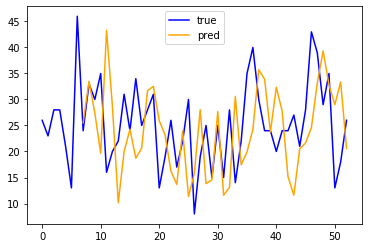

In [244]:
player_data_var = (player_data - player_data_ewma)

T = player_data_var.shape[0]
N = nbr_innings_to_test # nbr of rows
M = int(T/N) # total nbr of columns
M1 = M - 1 # nbr of columns for training
key1 = str(player_name) 
nbrSingValuesToKeep = 5

trainDF = player_data_var.iloc[0:M1*N]
testDF = player_data_var.iloc[M1*N:].reset_index(drop=True)

mod_var = SVDModel(key1, nbrSingValuesToKeep, N, M1, probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=[], includePastDataOnly=True)
mod_var.fit(trainDF)

pred = np.dot(window_stack(np.reshape(player_data_var.values.T,[1,player_data_var.shape[0]]).T, 1, N-1), mod_var.weights)
pred = np.concatenate((np.array([np.nan]*(N-1)),pred[:-1]))
var_pred = pd.DataFrame(index=range(0, len(pred)), data={player_name: pred})

plt.plot((player_data), color="blue", label="true")
plt.plot((ts_pred+var_pred), color="orange", label="pred")
plt.legend()

/Users/saeyoung/Documents/GitHub/mrsc/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


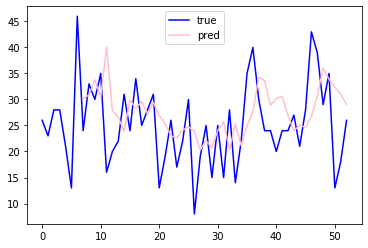

In [252]:
player_data_var = (player_data - player_data_ewma) ** 2

T = player_data_var.shape[0]
N = nbr_innings_to_test # nbr of rows
M = int(T/N) # total nbr of columns
M1 = M - 1 # nbr of columns for training
key1 = str(player_name) 
nbrSingValuesToKeep = 3

trainDF = player_data_var.iloc[0:M1*N]
testDF = player_data_var.iloc[M1*N:].reset_index(drop=True)

mod_var = SVDModel(key1, nbrSingValuesToKeep, N, M1, probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=[], includePastDataOnly=True)
mod_var.fit(trainDF)

pred = np.dot(window_stack(np.reshape(player_data_var.values.T,[1,player_data_var.shape[0]]).T, 1, N-1), mod_var.weights)
pred = np.concatenate((np.array([np.nan]*(N-1)),pred[:-1]))
var_pred = pd.DataFrame(index=range(0, len(pred)), data={player_name: pred})

plt.plot((player_data), color="blue", label="true")
plt.plot((ts_pred+np.sqrt(var_pred)), color="pink", label="pred")
plt.legend()

In [251]:
testDF

,Stephen Curry
0,25.163614
1,1.678857
2,2.049235
3,1.258168
4,21.561364
5,2.304934
6,217.211749
7,112.590733
8,2.344958
9,54.730977


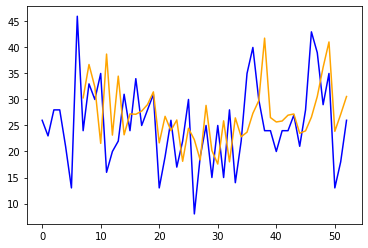

In [242]:
plt.plot((player_data), color="blue")
# plt.plot((player_data - ts_pred), color="green")

plt.plot((ts_pred+var_pred), color="orange")

In [58]:
var_pred

,Stephen Curry
0,NaN
1,NaN
2,NaN
3,NaN
4,1.343894
5,0.258160
6,1.130322
7,11.023230
8,97.346074
9,17.198767


In [ ]:

mod_test = SVDModel(key1, nbrSingValuesToKeep, N, M1, probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=[], includePastDataOnly=True)
allDF = pd.DataFrame(index=range(0, M*N), data={key1: player_data_ewma})

mod_test.fit(allDF)
imputedDF = mod_test.denoisedDF()

varDF = (player_data_ewma - imputedDF)**2

In [377]:
len(player_data_ewma)

36

In [379]:
imputedDF.shape

(33, 1)

In [368]:
player_data_ewma

array([27.        , 17.55      , 19.91840133, 18.49853491, 20.55496697,
       18.11739674, 19.22965141, 19.18995501, 18.83867552, 18.86296959,
       19.1679085 , 17.78275308, 16.89513468, 17.16111021, 18.24429893,
       18.21515645, 17.02520878, 16.56607522, 17.62226711, 17.44362988,
       17.39549536, 17.46022648, 17.1998658 , 17.49309299, 17.85688365,
       17.66588195, 17.59790659, 17.13172858, 17.01768503, 17.21634279,
       17.59364431, 17.23688913, 17.41121651, 17.46922146, 17.71773042,
       16.76631403])

In [369]:
imputedDF

NameError: name 'imputedDF' is not defined

In [ ]:


forecastArray = []
for i in range(0, len(testDF)):
    print(i)
    pastPoints = np.zeros(N - 1)  # need an N-1 length vector of past point
    j = 0
    if (i < N - 1):  # the first prediction uses the end of the training data
        while (j < N - 1 - i):
            pastPoints[j] = varDF[len(trainDF) - (N - 1 - i) + j]
            j += 1

    if (j < N - 1):  # use the new test data
        pastPoints[j:] = testDF[key1].values[i - (N - 1) + j:i]
    
    print(pastPoints)
    keyToSeriesDFNew = pd.DataFrame(data={key1: pastPoints})
    prediction = mod_var.predict(pd.DataFrame(data={}), keyToSeriesDFNew, bypassChecks=False)
    forecastArray.append(prediction)
    print(forecastArray)
estimates = np.concatenate((imputedDf[key1].values, forecastArray), axis=0)

# Real stuff

In [9]:
# player_name = "LeBron James"
player_list = ['Stephen Curry', 'Kevin Durant', 'LeBron James', 'Russell Westbrook', 'James Harden', 'Paul George', 'Kyrie Irving', 'Chris Paul']
player_name = player_list[6]

metric = "PTS_G"
# game_id = 21501020
game_date = "2017-02-13"

nbr_innings_to_test = 4
moving_avg_window = 15
nbrSingValuesToKeep = 5

ts pred with ewma
TEST


/Users/saeyoung/Documents/GitHub/mrsc/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


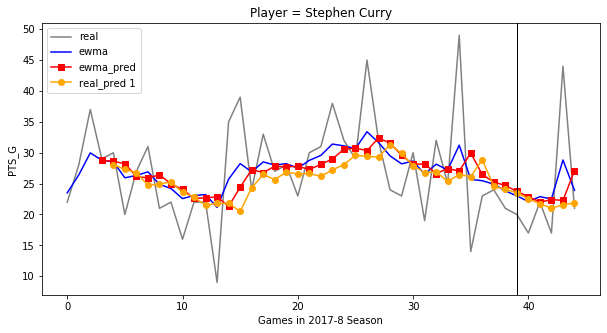

2018-02-26 07:30:00
45
40


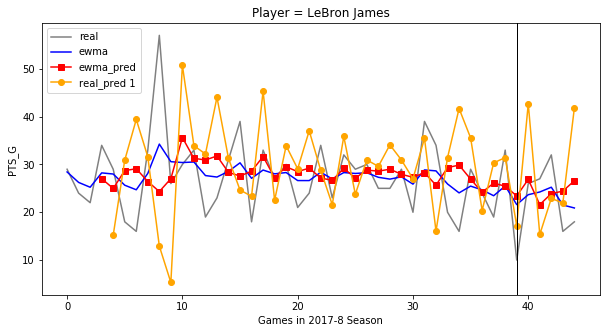

2018-01-23 08:00:00
45
40


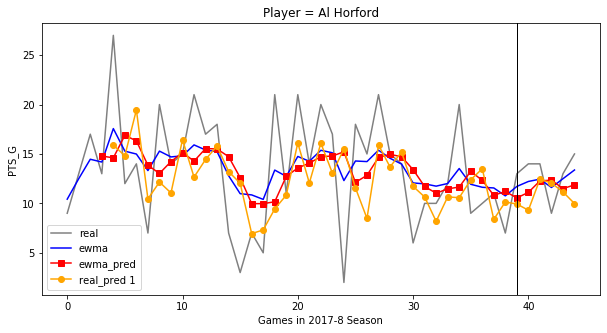

2018-01-29 09:00:00
45
40


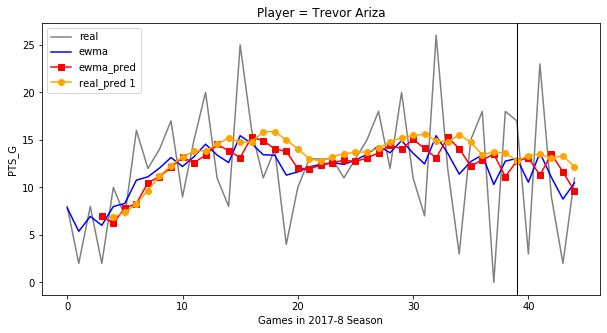

2018-02-25 08:00:00
45
40


In [353]:
print("ts pred with ewma")
print("TEST")

metric = "PTS_G"
nbr_innings_to_test = 4
moving_avg_window = 7
nbrSingValuesToKeep = 5
xlabel = 'Games in 2017-8 Season'
start_date = "2017-10-01"
end_date = "2018-10-01"

# player_list = ['Stephen Curry', 'Kevin Durant', 'LeBron James', 'Russell Westbrook', 'James Harden', 'Paul George', 'Kyrie Irving', 'Chris Paul']
# player_list = ['Al Horford','Trevor Ariza','Eric Gordon']
player_list = ['Stephen Curry', 'LeBron James','Al Horford','Trevor Ariza']

##############################################
for player_name in player_list:

    plt.figure(figsize=(10,5))

    player_stat = stats_game[(stats_game.Player == player_name) & (stats_game.date > start_date) & (stats_game.date < end_date)]
    game_date = player_stat.iloc[45]['date']

    # true data
    player_data =  player_stat.loc[player_stat.date < game_date, metric].reset_index(drop=True).rename(player_name).to_frame()
    plt.plot(player_data, label="real", color="grey")

    # ewma data
    player_data_ewma = run_ewma(player_data, moving_avg_window)
    player_data_ewma = pd.DataFrame(index=range(0, len(player_data_ewma)), data={player_name: player_data_ewma})
    plt.plot(player_data_ewma, label="ewma", color="blue")

    # ewma pred
    ts_pred, interv = ts_estimate(player_data_ewma.values.flatten(), player_name, metric, game_date, nbr_innings_to_test, moving_avg_window, nbrSingValuesToKeep)
    ts_pred = pd.DataFrame(index=range(0, len(ts_pred)), data={player_name: ts_pred})
    plt.plot(ts_pred, label="ewma_pred", color="red", marker='s')
    
    # recover X(t) - by ewma equation
    alpha = 2/(moving_avg_window+1)
    real_pred = [np.nan]*nbr_innings_to_test
    for loc in range(nbr_innings_to_test,ts_pred.shape[0],1):
        x_t = (ts_pred.iloc[loc] - player_data_ewma.iloc[loc-1] * (1-alpha)) /alpha
        real_pred.append(x_t)
    plt.plot(real_pred, label="real_pred 1", color="orange", marker='o')

#     # recover X(t) - by variance estimation
#     player_data_var = (player_data - player_data_ewma)
#     T = player_data_var.shape[0]
#     N = nbr_innings_to_test # nbr of rows
#     M = int(T/N) # total nbr of columns
#     M1 = M - 1 # nbr of columns for training
#     key1 = str(player_name) 
#     nbrSingValuesToKeep = 5

#     trainDF = player_data_var.iloc[0:M1*N]
#     testDF = player_data_var.iloc[M1*N:].reset_index(drop=True)

#     mod_var = SVDModel(key1, nbrSingValuesToKeep, N, M1, probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=[], includePastDataOnly=True)
#     mod_var.fit(trainDF)

#     pred = np.dot(window_stack(np.reshape(player_data_var.values.T,[1,player_data_var.shape[0]]).T, 1, N-1), mod_var.weights)
#     pred = np.concatenate((np.array([np.nan]*(N-1)),pred[:-1]))
#     var_pred = pd.DataFrame(index=range(0, len(pred)), data={player_name: pred})
#     plt.plot((ts_pred+var_pred), color="pink", label="real_pred 2",marker='o')

    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(metric)
    plt.axvline(x=interv-1, linewidth=1, color='black', label='Training End')
    plt.title('Player = '+player_name)
    plt.show()
    
    print(game_date)
    print(player_data.shape[0])
    print(interv)

ts pred with ewma
TEST


/Users/saeyoung/Documents/GitHub/mrsc/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


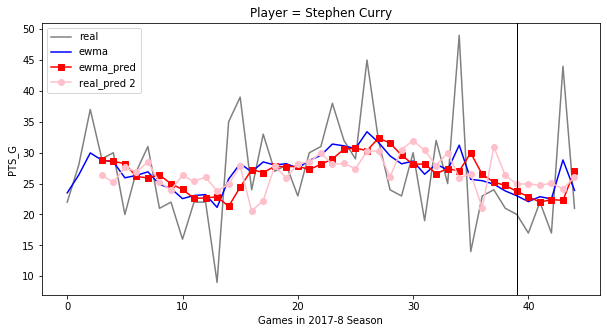

2018-02-26 07:30:00
45
40


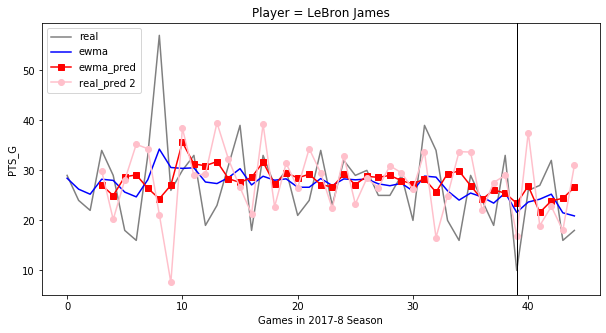

2018-01-23 08:00:00
45
40


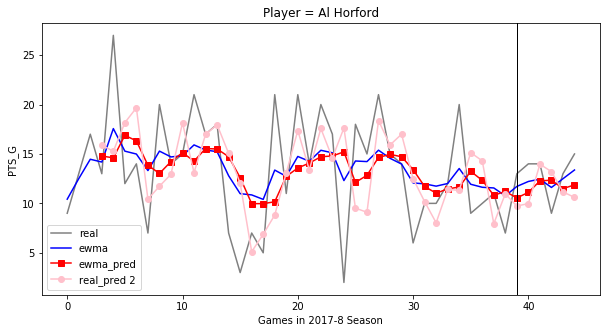

2018-01-29 09:00:00
45
40


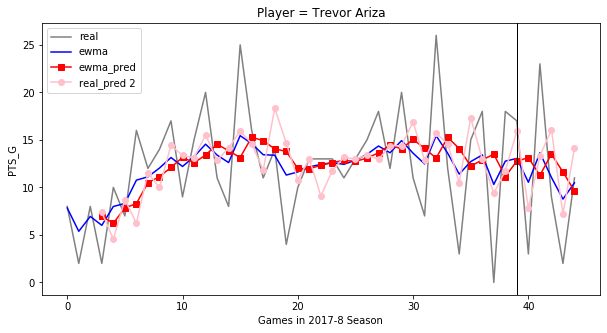

2018-02-25 08:00:00
45
40


In [354]:
print("ts pred with ewma")
print("TEST")

metric = "PTS_G"
nbr_innings_to_test = 4
moving_avg_window = 7
nbrSingValuesToKeep = 5
xlabel = 'Games in 2017-8 Season'
start_date = "2017-10-01"
end_date = "2018-10-01"

# player_list = ['Stephen Curry', 'Kevin Durant', 'LeBron James', 'Russell Westbrook', 'James Harden', 'Paul George', 'Kyrie Irving', 'Chris Paul']
# player_list = ['Al Horford','Trevor Ariza','Eric Gordon']
player_list = ['Stephen Curry', 'LeBron James','Al Horford','Trevor Ariza']

##############################################
for player_name in player_list:

    plt.figure(figsize=(10,5))

    player_stat = stats_game[(stats_game.Player == player_name) & (stats_game.date > start_date) & (stats_game.date < end_date)]
    game_date = player_stat.iloc[45]['date']

    # true data
    player_data =  player_stat.loc[player_stat.date < game_date, metric].reset_index(drop=True).rename(player_name).to_frame()
    plt.plot(player_data, label="real", color="grey")

    # ewma data
    player_data_ewma = run_ewma(player_data, moving_avg_window)
    player_data_ewma = pd.DataFrame(index=range(0, len(player_data_ewma)), data={player_name: player_data_ewma})
    plt.plot(player_data_ewma, label="ewma", color="blue")

    # ewma pred
    ts_pred, interv = ts_estimate(player_data_ewma.values.flatten(), player_name, metric, game_date, nbr_innings_to_test, moving_avg_window, nbrSingValuesToKeep)
    ts_pred = pd.DataFrame(index=range(0, len(ts_pred)), data={player_name: ts_pred})
    plt.plot(ts_pred, label="ewma_pred", color="red", marker='s')
    
#     # recover X(t) - by ewma equation
#     alpha = 2/(moving_avg_window+1)
#     real_pred = [np.nan]*nbr_innings_to_test
#     for loc in range(nbr_innings_to_test,ts_pred.shape[0],1):
#         x_t = (ts_pred.iloc[loc] - player_data_ewma.iloc[loc-1] * (1-alpha)) /alpha
#         real_pred.append(x_t)
#     plt.plot(real_pred, label="real_pred 1", color="orange", marker='o')

    # recover X(t) - by variance estimation
    player_data_var = (player_data - player_data_ewma)
    T = player_data_var.shape[0]
    N = nbr_innings_to_test # nbr of rows
    M = int(T/N) # total nbr of columns
    M1 = M - 1 # nbr of columns for training
    key1 = str(player_name) 
    nbrSingValuesToKeep = 5

    trainDF = player_data_var.iloc[0:M1*N]
    testDF = player_data_var.iloc[M1*N:].reset_index(drop=True)

    mod_var = SVDModel(key1, nbrSingValuesToKeep, N, M1, probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=[], includePastDataOnly=True)
    mod_var.fit(trainDF)

    pred = np.dot(window_stack(np.reshape(player_data_var.values.T,[1,player_data_var.shape[0]]).T, 1, N-1), mod_var.weights)
    pred = np.concatenate((np.array([np.nan]*(N-1)),pred[:-1]))
    var_pred = pd.DataFrame(index=range(0, len(pred)), data={player_name: pred})
    plt.plot((ts_pred+var_pred), color="pink", label="real_pred 2",marker='o')

    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(metric)
    plt.axvline(x=interv-1, linewidth=1, color='black', label='Training End')
    plt.title('Player = '+player_name)
    plt.show()
    
    print(game_date)
    print(player_data.shape[0])
    print(interv)

In [356]:
metric = "PTS_G"
nbr_innings_to_test = 4
moving_avg_window = 7
nbrSingValuesToKeep = 5

start_date = "2017-10-01"
end_date = "2018-10-01"

test_period = 3

players = stats_game[(stats_game.date > start_date) & (stats_game.date < end_date)].groupby(['Player']).count()['date'].rename('count')
players_of_interest = list(players[players>38].index)

##############################################
run_analysis(test_period, metric, players_of_interest,start_date,end_date, stats_game, nbr_innings_to_test, moving_avg_window, nbrSingValuesToKeep)


*** PTS_G ***
number of players tested:  340


/Users/saeyoung/Documents/GitHub/mrsc/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


MAPE:  0.1516745426432733
ewma accuracy
RMSE:  1.5043094769714906
X(t) recovery - by ewma equation
RMSE:  5.956078031365966
X(t) recovery - by variance estimation
RMSE:  5.898285968508303
-------------


In [358]:
metric = "PTS_G"
nbr_innings_to_test = 4
moving_avg_window = 7
nbrSingValuesToKeep = 5

start_date = "2017-10-01"
end_date = "2018-10-01"

test_period = 3
min_num_game = 45

players = stats_game[(stats_game.date > start_date) & (stats_game.date < end_date)].groupby(['Player']).count()['date'].rename('count')
players_of_interest = list(players[players>min_num_game].index)

##############################################
run_analysis(test_period,min_num_game, metric, players_of_interest,start_date,end_date, stats_game, nbr_innings_to_test, moving_avg_window, nbrSingValuesToKeep)


*** PTS_G ***
number of players tested:  323


/Users/saeyoung/Documents/GitHub/mrsc/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


MAPE:  0.1502661699087967
ewma accuracy
RMSE:  1.4870920477508824
X(t) recovery - by ewma equation
RMSE:  5.744748396876871
X(t) recovery - by variance estimation
RMSE:  5.365097339497328
-------------


In [385]:
metric = "PTS_G"
nbr_innings_to_test = 4
moving_avg_window = 7
nbrSingValuesToKeep = 5

start_date = "2017-10-01"
end_date = "2018-10-01"

test_period = 3
min_num_game = 45

players = stats_game[(stats_game.date > start_date) & (stats_game.date < end_date)].groupby(['Player']).count()['date'].rename('count')
players_of_interest = list(players[players>min_num_game].index)

standing = stats_game[stats_game.Player.isin(players_of_interest)].groupby("Player").mean().PTS_G
players_of_interest_tier1 = standing[standing >= 20].index.to_list()
players_of_interest_tier2 = standing[(standing < 20)&(standing >= 10)].index.to_list()

print("more than 20 pts")
run_analysis(test_period,min_num_game, metric, players_of_interest_tier1,start_date,end_date, stats_game, nbr_innings_to_test, moving_avg_window, nbrSingValuesToKeep)
print("more than 10 pts, less than 20 pts")
run_analysis(test_period,min_num_game, metric, players_of_interest_tier2,start_date,end_date, stats_game, nbr_innings_to_test, moving_avg_window, nbrSingValuesToKeep)


more than 20 pts
*** PTS_G ***
number of players tested:  18


/Users/saeyoung/Documents/GitHub/mrsc/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


MAPE:  0.07260439592931109
ewma accuracy
RMSE:  1.9945867993771798
X(t) recovery - by ewma equation
RMSE:  7.723460941074102
X(t) recovery - by variance estimation
RMSE:  7.880791943100704
-------------
more than 10 pts, less than 20 pts
*** PTS_G ***
number of players tested:  124
MAPE:  0.11803417988327311
ewma accuracy
RMSE:  1.6548789900939227
X(t) recovery - by ewma equation
RMSE:  6.5066015679875235
X(t) recovery - by variance estimation
RMSE:  5.956468641766492
-------------


NameError: name 'stats' is not defined

ts pred with ewma
TEST


/Users/saeyoung/Documents/GitHub/mrsc/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


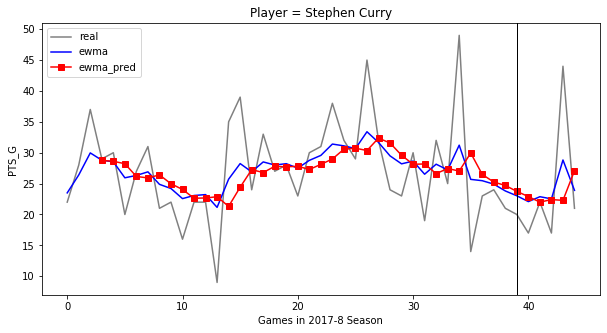

2018-02-26 07:30:00
45
40


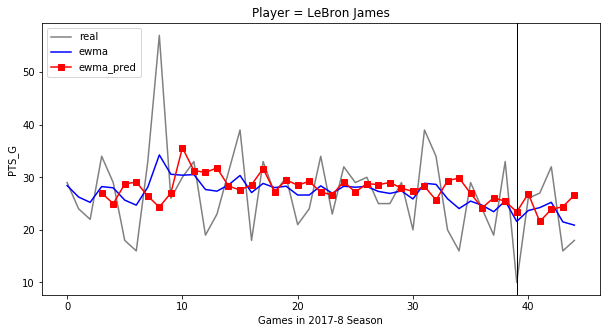

2018-01-23 08:00:00
45
40


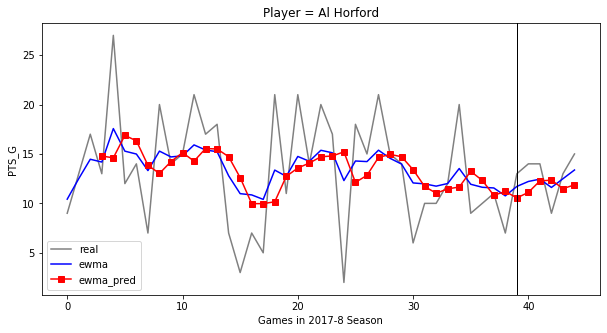

2018-01-29 09:00:00
45
40


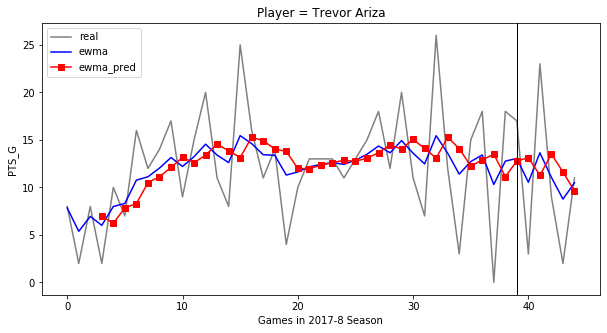

2018-02-25 08:00:00
45
40


In [11]:
print("ts pred with ewma")
print("TEST")

metric = "PTS_G"
nbr_innings_to_test = 4
moving_avg_window = 7
nbrSingValuesToKeep = 5
xlabel = 'Games in 2017-8 Season'
start_date = "2017-10-01"
end_date = "2018-10-01"

# player_list = ['Stephen Curry', 'Kevin Durant', 'LeBron James', 'Russell Westbrook', 'James Harden', 'Paul George', 'Kyrie Irving', 'Chris Paul']
# player_list = ['Al Horford','Trevor Ariza','Eric Gordon']
player_list = ['Stephen Curry', 'LeBron James','Al Horford','Trevor Ariza']

##############################################
for player_name in player_list:

    plt.figure(figsize=(10,5))

    player_stat = stats_game[(stats_game.Player == player_name) & (stats_game.date > start_date) & (stats_game.date < end_date)]
    game_date = player_stat.iloc[45]['date']

    # true data
    player_data =  player_stat.loc[player_stat.date < game_date, metric].reset_index(drop=True).rename(player_name).to_frame()
    plt.plot(player_data, label="real", color="grey")

    # ewma data
    player_data_ewma = run_ewma(player_data, moving_avg_window)
    player_data_ewma = pd.DataFrame(index=range(0, len(player_data_ewma)), data={player_name: player_data_ewma})
    plt.plot(player_data_ewma, label="ewma", color="blue")

    # ewma pred
    ts_pred, interv = ts_estimate(player_data_ewma.values.flatten(), player_name, metric, game_date, nbr_innings_to_test, moving_avg_window, nbrSingValuesToKeep)
    ts_pred = pd.DataFrame(index=range(0, len(ts_pred)), data={player_name: ts_pred})
    plt.plot(ts_pred, label="ewma_pred", color="red", marker='s')
    
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(metric)
    plt.axvline(x=interv-1, linewidth=1, color='black', label='Training End')
    plt.title('Player = '+player_name)
    plt.show()
    
    print(game_date)
    print(player_data.shape[0])
    print(interv)

In [572]:
for loc in range(50,53):
    print(loc)
    print("ewma following the rule: ", alpha * player_data.values[loc] + (1-alpha)*player_data_ewma[loc-1])
    print("the computed ewma: ", player_data_ewma[loc])
    print()

50
ewma following the rule:  [27.34028341]
the computed ewma:  27.338022158790675

51
ewma following the rule:  [26.17076939]
the computed ewma:  26.169642184057402

52
ewma following the rule:  [26.14843691]
the computed ewma:  26.148418995198938



In [574]:
alpha = 2/(moving_avg_window+1)

x_t_list = [np.nan]*nbr_innings_to_test
for loc in range(nbr_innings_to_test,len(ts_pred),1):
    x_t = (player_data_ewma[loc] - player_data_ewma[loc-1] * (1-alpha)) /alpha
    x_t_list.append(x_t)
    print("pred: ", x_t)
    print("real: ", player_data.iloc[loc].values)
    print()
    

pred:  15.272775398884335
real:  [21]

pred:  3.194355242425928
real:  [13]

pred:  61.31712801746349
real:  [46]

pred:  22.331297016257196
real:  [24]

pred:  35.75977634965906
real:  [33]

pred:  30.81106999118714
real:  [30]

pred:  37.05925139427097
real:  [35]

pred:  12.662735500602366
real:  [16]

pred:  18.468032978435133
real:  [20]

pred:  21.25720638300845
real:  [22]

pred:  31.862281924835145
real:  [31]

pred:  23.696017552403475
real:  [24]

pred:  34.92758174734968
real:  [34]

pred:  24.794168757992793
real:  [25]

pred:  28.104221472289993
real:  [28]

pred:  31.30104258602597
real:  [31]

pred:  12.065634341980967
real:  [13]

pred:  18.632596177452456
real:  [19]

pred:  26.063223481507492
real:  [26]

pred:  16.667219913515737
real:  [17]

pred:  21.932107110556103
real:  [22]

pred:  30.204979616820367
real:  [30]

pred:  7.540975298701824
real:  [8]

pred:  18.919140475531435
real:  [19]

pred:  25.065996651875736
real:  [25]

pred:  14.864794022438588
real:  [1

In [569]:
alpha = 2/(moving_avg_window+1)

x_t_list = [np.nan]*nbr_innings_to_test
for loc in range(nbr_innings_to_test,len(ts_pred),1):
    x_t = (ts_pred[loc] - player_data_ewma[loc-1] * (1-alpha)) /alpha
    x_t_list.append(x_t)
    print("pred: ", x_t)
    print("real: ", player_data.iloc[loc].values)
    print()

pred:  24.89792479173107
real:  [21]

pred:  24.048072624514333
real:  [13]

pred:  22.45988114011874
real:  [46]

pred:  27.072310481888024
real:  [24]

pred:  23.576580529804517
real:  [33]

pred:  26.985826415599462
real:  [30]

pred:  26.641293046545485
real:  [35]

pred:  27.997275541132097
real:  [16]

pred:  25.959736517035083
real:  [20]

pred:  26.24973614270027
real:  [22]

pred:  25.180564081032855
real:  [31]

pred:  25.606214216313447
real:  [24]

pred:  24.76952042417807
real:  [34]

pred:  26.224759052164643
real:  [25]

pred:  25.43108083966891
real:  [28]

pred:  26.180561399898778
real:  [31]

pred:  26.469698762052786
real:  [13]

pred:  24.662545601129864
real:  [19]

pred:  24.836141027584915
real:  [26]

pred:  24.428370920142783
real:  [17]

pred:  23.08146336966314
real:  [22]

pred:  23.314450910336433
real:  [30]

pred:  23.660990144803208
real:  [8]

pred:  21.412606412541976
real:  [19]

pred:  22.16393176470433
real:  [25]

pred:  21.714435251921913
real:  

ts pred with actual data


/Users/saeyoung/Documents/GitHub/mrsc/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


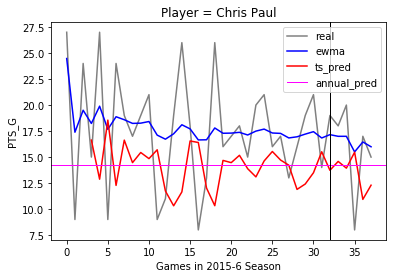

In [408]:
print("ts pred with actual data")
player_stat = stats_game[(stats_game.Player == player_name) & (stats_game.date > "2016-10-01") & (stats_game.date < "2017-10-01")]

player_data =  player_stat.loc[player_stat.date < game_date, metric].reset_index(drop=True).rename(player_name).to_frame()
plt.plot(player_data, label="real", color="grey")

player_data_ewma = run_ewma(player_data, moving_avg_window)
plt.plot(player_data_ewma, label="ewma", color="blue")

ts_pred, interv = ts_estimate(player_data.values.flatten(), player_name, metric, game_date, nbr_innings_to_test, moving_avg_window, nbrSingValuesToKeep)
plt.plot(ts_pred, label="ts_pred", color="red")

player_annual_stat = annual_pred[player_name][metric]
plt.axhline(y=player_annual_stat,  linewidth=1, color='magenta', label='annual_pred')

plt.legend()
plt.xlabel('Games in 2015-6 Season')
plt.ylabel(metric)
plt.axvline(x=interv, linewidth=1, color='black', label='Training End')
plt.title('Player = '+player_name)
plt.show()


2017-01-10 10:30:00


/Users/saeyoung/Documents/GitHub/mrsc/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


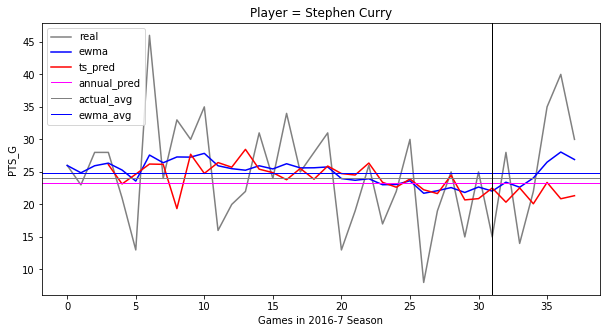

2017-01-10 10:30:00


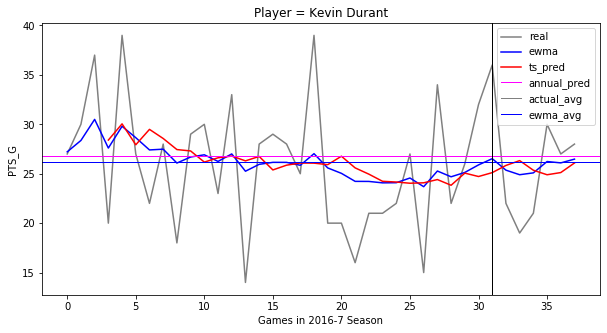

2017-01-21 08:30:00


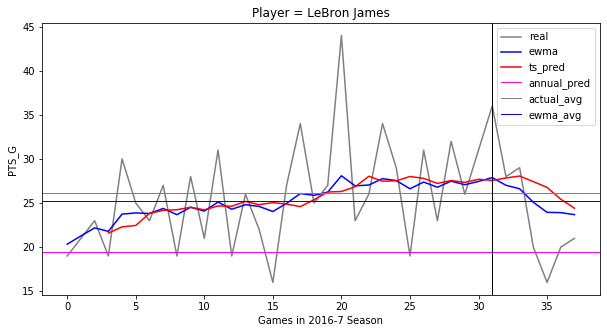

2017-01-09 08:00:00


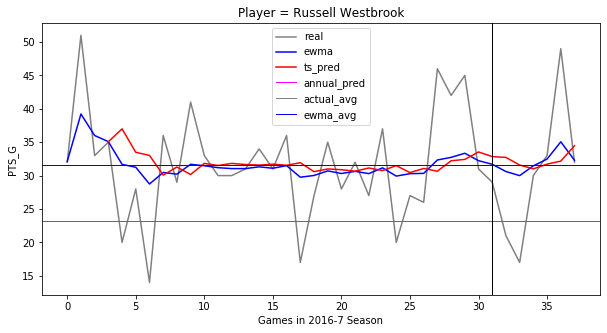

2017-01-08 06:00:00


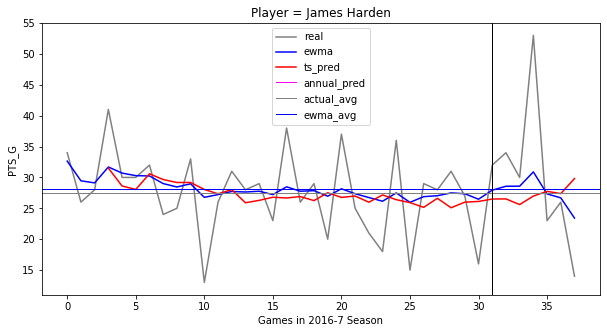

2017-01-27 07:00:00


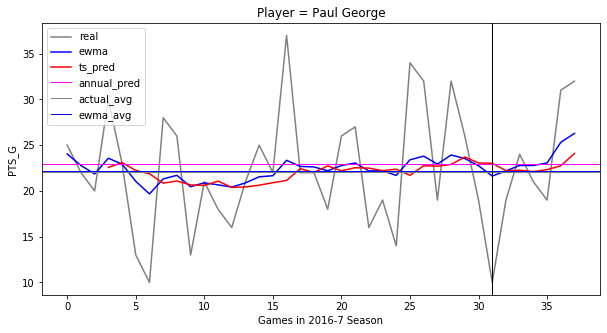

2017-01-25 07:00:00


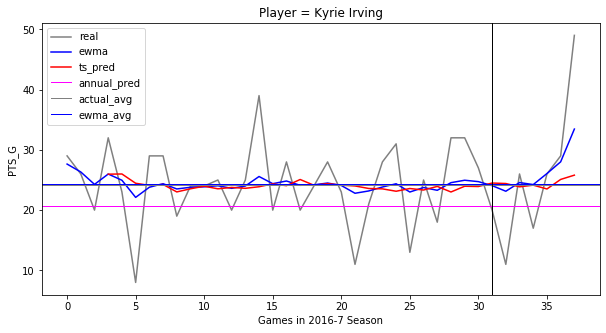

2017-03-01 10:30:00


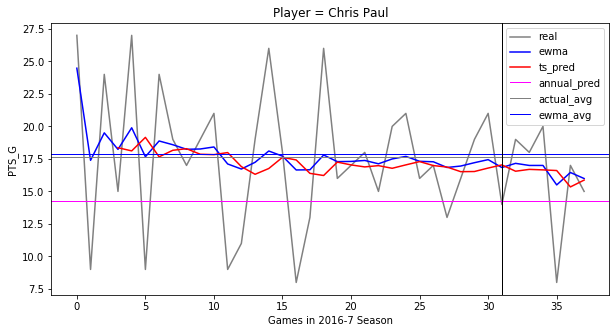

In [419]:
metric = "PTS_G"
nbr_innings_to_test = 4
moving_avg_window = 15
nbrSingValuesToKeep = 5

player_list = ['Stephen Curry', 'Kevin Durant', 'LeBron James', 'Russell Westbrook', 'James Harden', 'Paul George', 'Kyrie Irving', 'Chris Paul']

for player_name in player_list:
    plt.figure(figsize=(10,5))
    
    player_stat = stats_game[(stats_game.Player == player_name) & (stats_game.date > "2016-10-01") & (stats_game.date < "2017-10-01")]
    game_date = player_stat.iloc[38]['date']
    print(game_date)

    player_data =  player_stat.loc[player_stat.date < game_date, metric].reset_index(drop=True).rename(player_name).to_frame()
    plt.plot(player_data, label="real", color="grey")

    player_data_ewma = run_ewma(player_data, moving_avg_window)
    plt.plot(player_data_ewma, label="ewma", color="blue")

    ts_pred, interv = ts_estimate(player_data_ewma, player_name, metric, game_date, nbr_innings_to_test, moving_avg_window, nbrSingValuesToKeep)
    plt.plot(ts_pred, label="ts_pred", color="red")

    player_annual_stat = annual_pred[player_name][metric]
    plt.axhline(y=player_annual_stat,  linewidth=1, color='magenta', label='annual_pred')
    plt.axhline(y=player_data.iloc[:interv].mean().values,  linewidth=1, color='grey', label='actual_avg')
    plt.axhline(y=player_data_ewma[:interv].mean(),  linewidth=1, color='blue', label='ewma_avg')

    plt.legend()
    plt.xlabel('Games in 2016-7 Season')
    plt.ylabel(metric)
    plt.axvline(x=interv-1, linewidth=1, color='black', label='Training End')
    plt.title('Player = '+player_name)
    plt.show()


In [410]:
players = stats_game[(stats_game.date > "2016-10-01") & (stats_game.date < "2017-10-01")].groupby(['Player']).count()['date'].rename('count')
players_of_interest = list(players[players>38].index)


nbr_innings_to_test = 4
moving_avg_window = 15
nbrSingValuesToKeep = 5

run_analysis('PTS_G', players_of_interest, stats_game, nbr_innings_to_test,moving_avg_window, nbrSingValuesToKeep)

*** PTS_G ***


/Users/saeyoung/Documents/GitHub/mrsc/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


RMSE:  0.8018189841057553
MAPE:  0.08728301855835052
-------------


In [143]:
df = pd.read_csv("../data/nba-834/2005-06_pbp.csv")
scores = df[["GAME_ID",'SCORE']].dropna()
final_scores = scores[scores.GAME_ID.shift(-1) != scores.GAME_ID]
final_scores = pd.concat([final_scores.GAME_ID, final_scores.SCORE.str.split("-", expand=True).astype(int)], axis=1)
final_scores.columns = ["GAME_ID","AWAY","HOME"]
final_scores['WINNER'] = np.nan
final_scores.WINNER[final_scores.AWAY > final_scores.HOME] = "AWAY"
final_scores.WINNER[final_scores.AWAY < final_scores.HOME] = "HOME"

/Users/saeyoung/Documents/GitHub/mrsc/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/saeyoung/Documents/GitHub/mrsc/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [144]:
final_scores

,GAME_ID,AWAY,HOME,WINNER
453,20500748,83,90,HOME
911,20501134,99,86,AWAY
1406,20500538,107,92,AWAY
1877,20500969,103,105,HOME
2303,20500500,86,95,HOME
...,...,...,...,...
552355,20500651,93,94,HOME
552808,20500141,101,113,HOME
553243,20501013,93,92,AWAY
553684,20500937,108,96,AWAY


In [132]:

(final_scores.WINNER)

453       HOME
911       AWAY
1406      AWAY
1877      HOME
2303      HOME
          ... 
552355    HOME
552808    HOME
553243    AWAY
553684    AWAY
554119    HOME
Name: WINNER, Length: 1230, dtype: object

,GAME_ID,AWAY,HOME
453,83 - 90,83,90
911,99 - 86,99,86
1406,107 - 92,107,92
1877,103 - 105,103,105
2303,86 - 95,86,95
...,...,...,...
552355,93 - 94,93,94
552808,101 - 113,101,113
553243,93 - 92,93,92
553684,108 - 96,108,96


In [380]:
N=3
B = np.identity(N)*2 - np.identity(N+1)[:N,1:] - np.identity(N+1)[1:,:N]
B[0,0]=1
B[N-1,N-1]=1
I = np.identity(N)
L = np.kron(B,I) + np.kron(I,B)

ind = 9
K = np.delete(L, ind-1, 0)
K = np.delete(K, ind-1, 1)

f = np.zeros([N**2-1,1])
f[0] = 1
u = np.dot(np.linalg.inv(K),f)

In [381]:
u

array([[1.5 ],
       [1.  ],
       [0.75],
       [1.  ],
       [0.75],
       [0.5 ],
       [0.75],
       [0.5 ]])

In [386]:
N = 10
B = np.identity(N)*2 - np.identity(N+1)[:N,1:] - np.identity(N+1)[1:,:N]
B[0,0]=1
B[N-1,N-1]=1
I = np.identity(N)
L = np.kron(B,I) + np.kron(I,B)

ind = 56
K = np.delete(L, ind-1, 0)
K = np.delete(K, ind-1, 1)

f = np.zeros([N**2-1,1])
f[54] = 1
u = np.dot(np.linalg.inv(K),f)

In [391]:
u[54]

array([0.50568843])

In [316]:
B = np.array([[-1,1,0],[-1,2,-1],[0,-1,1]])
I = np.identity(3)
L = np.kron(B,I) + np.kron(I,B)
K = L[:8,:8]
f = np.zeros([8,1])
f[0] = -1
u = np.dot(np.linalg.inv(K),f)

In [272]:
A = np.array([[-1,1,0,0],[-1,0,1,0],[0,0,-1,1],[0,-1,0,1],[-1,0,0,1]])

In [274]:
np.dot(A.T,A)

array([[ 3, -1, -1, -1],
       [-1,  2,  0, -1],
       [-1,  0,  2, -1],
       [-1, -1, -1,  3]])

ts pred with ewma
TEST


/Users/saeyoung/Documents/GitHub/mrsc/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


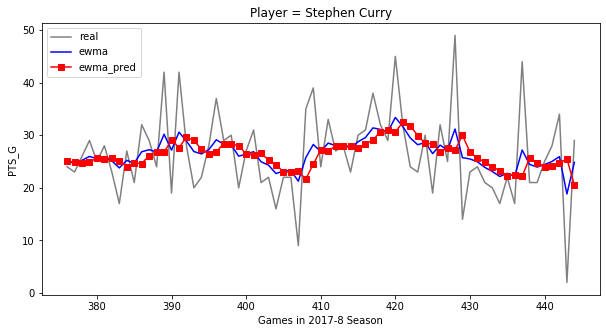

2013-03-13 19:00:00
445
440


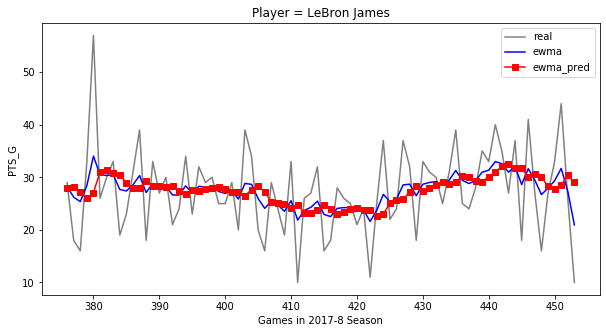

2013-03-13 19:00:00
454
448


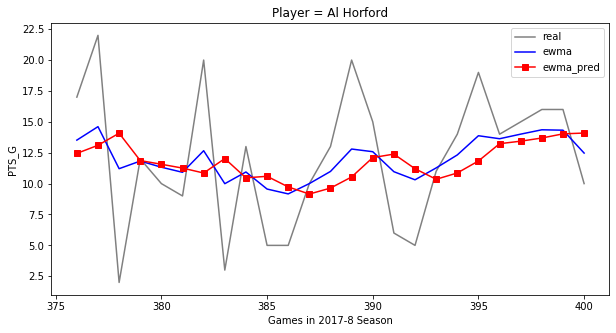

2013-03-13 19:00:00
401
396


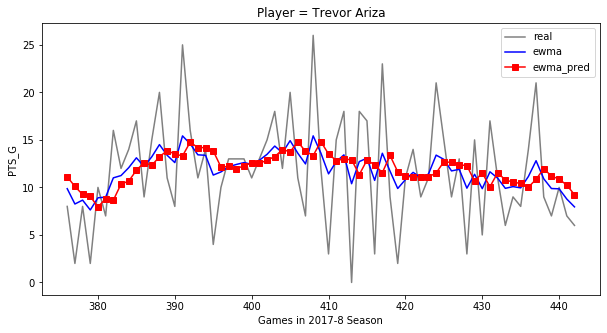

2013-03-13 19:00:00
443
436


In [43]:
print("ts pred with ewma")
print("TEST")

metric = "PTS_G"
nbr_innings_to_test = 4
moving_avg_window = 7
nbrSingValuesToKeep = 5
xlabel = 'Games in 2017-8 Season'
start_date = "2012-10-01"
interv_date = "2017-10-01"
end_date = "2018-10-01"

# player_list = ['Stephen Curry', 'Kevin Durant', 'LeBron James', 'Russell Westbrook', 'James Harden', 'Paul George', 'Kyrie Irving', 'Chris Paul']
# player_list = ['Al Horford','Trevor Ariza','Eric Gordon']
player_list = ['Stephen Curry', 'LeBron James','Al Horford','Trevor Ariza']

##############################################
for player_name in player_list:

    plt.figure(figsize=(10,5))

    player_stat = stats_game[(stats_game.Player == player_name) & (stats_game.date > start_date) & (stats_game.date < end_date)]

    # true data
    player_data =  player_stat[metric].reset_index(drop=True).rename(player_name).to_frame()
    player_data_pre =  player_stat.loc[player_stat.date < interv_date, metric].reset_index(drop=True).rename(player_name).to_frame()
    N=len(player_data_post)
    
    plt.plot(player_data[N:], label="real", color="grey")
    

    # ewma data
    player_data_ewma = run_ewma(player_data, moving_avg_window)
    player_data_ewma = pd.DataFrame(index=range(0, len(player_data_ewma)), data={player_name: player_data_ewma})
    plt.plot(player_data_ewma[N:], label="ewma", color="blue")

    # ewma pred
    ts_pred, interv = ts_estimate(player_data_ewma.values.flatten(), player_name, metric, game_date, nbr_innings_to_test, moving_avg_window, nbrSingValuesToKeep)
    ts_pred = pd.DataFrame(index=range(0, len(ts_pred)), data={player_name: ts_pred})
    plt.plot(ts_pred[N:], label="ewma_pred", color="red", marker='s')
    
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(metric)
#     plt.axvline(x=interv-1, linewidth=1, color='black', label='Training End')
    plt.title('Player = '+player_name)
    plt.show()
    
    print(game_date)
    print(player_data.shape[0])


In [47]:
one_game = stats_game[stats_game.nbaId == 21701228].Player.values

/Users/saeyoung/Documents/GitHub/mrsc/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


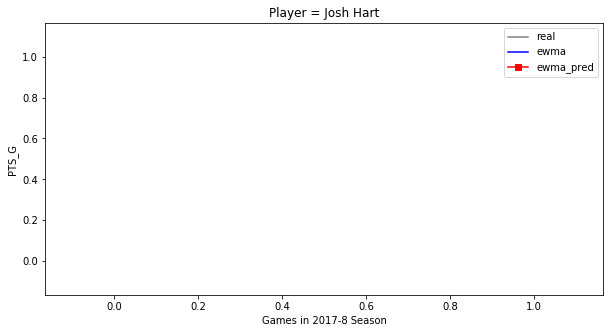

2013-03-13 19:00:00
63


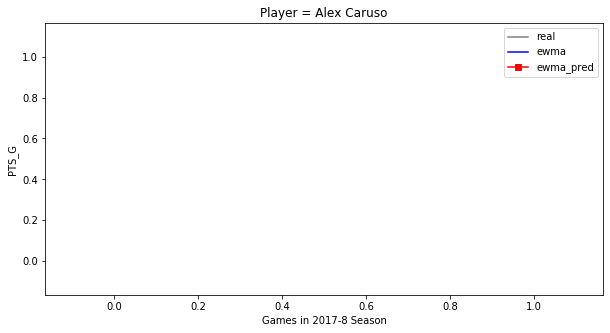

2013-03-13 19:00:00
37


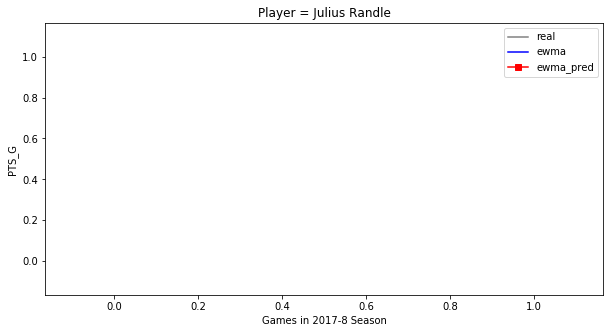

2013-03-13 19:00:00
238


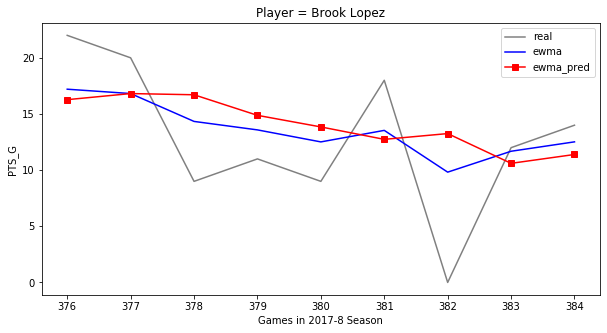

2013-03-13 19:00:00
385


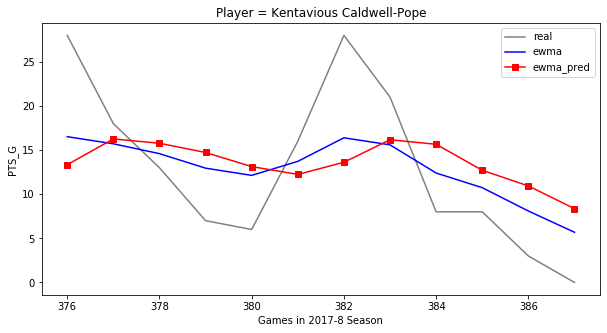

2013-03-13 19:00:00
388


ValueError: Shape of passed values is (2, 1), indices imply (6, 1)

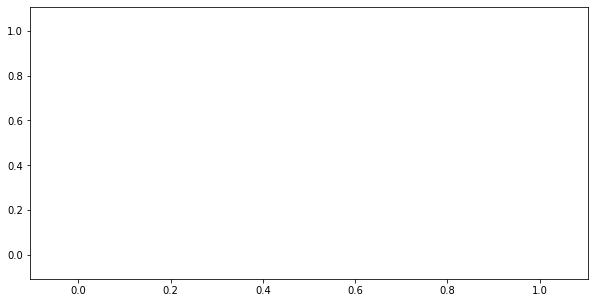

In [48]:
for player_name in one_game:

    plt.figure(figsize=(10,5))

    player_stat = stats_game[(stats_game.Player == player_name) & (stats_game.date > start_date) & (stats_game.date < end_date)]

    # true data
    player_data =  player_stat[metric].reset_index(drop=True).rename(player_name).to_frame()
    player_data_pre =  player_stat.loc[player_stat.date < interv_date, metric].reset_index(drop=True).rename(player_name).to_frame()
    N=len(player_data_post)
    
    plt.plot(player_data[N:], label="real", color="grey")
    

    # ewma data
    player_data_ewma = run_ewma(player_data, moving_avg_window)
    player_data_ewma = pd.DataFrame(index=range(0, len(player_data_ewma)), data={player_name: player_data_ewma})
    plt.plot(player_data_ewma[N:], label="ewma", color="blue")

    # ewma pred
    ts_pred, interv = ts_estimate(player_data_ewma.values.flatten(), player_name, metric, game_date, nbr_innings_to_test, moving_avg_window, nbrSingValuesToKeep)
    ts_pred = pd.DataFrame(index=range(0, len(ts_pred)), data={player_name: ts_pred})
    plt.plot(ts_pred[N:], label="ewma_pred", color="red", marker='s')
    
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(metric)
#     plt.axvline(x=interv-1, linewidth=1, color='black', label='Training End')
    plt.title('Player = '+player_name)
    plt.show()
    
    print(game_date)
    print(player_data.shape[0])